# Loading data and libraries

In [1]:
# !pip install mediapipe
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp
 
mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates
 
%matplotlib inline

In [2]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

# Image preprocessing : 
### our preprocessing will include
- Detecting faces from images
- Drawing landmarks on our images to increase performance
- Resizing our images 
- LabelEncoding
- Image Augmantation

# Landmarks :
We will use mediapipe to draw landmarks on our images after detecting faces and croping them

In [3]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) 
 
# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))
 
# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)
 
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [4]:
imgH, imgW, _=0,0,0 
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
    
    img_eye_lmks=None
    img_eye_lmks_chosen=None
    ts_thickness=1
    ts_circle_radius=2
    lmk_circle_radius=3                    


    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        if results.multi_face_landmarks:
            for faceLms in results.multi_face_landmarks:

                # For plotting Face Tessellation
                image_drawing_tool = image 
                
                # For plotting all eye landmarks
                image_eye_lmks = image.copy() if img_eye_lmks is None else img_eye_lmks
                
                # For plotting chosen eye landmarks
                img_eye_lmks_chosen = image.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
            
                # Initializing drawing utilities for plotting face mesh tessellation
                connections_drawing_spec = mp_drawing.DrawingSpec(
                    thickness=ts_thickness, 
                    circle_radius=ts_circle_radius, 
                    color=(255, 255, 255)
                )
                mp_drawing.draw_landmarks(
                image=image_drawing_tool,
                landmark_list=faceLms,
                connections=mp_facemesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=connections_drawing_spec,
                )
        
                # Get the object which holds the x, y, and z coordinates for each landmark
                landmarks = faceLms.landmark
            
                # Iterate over all landmarks.
                # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
                # get the denormalized coordinates and plot circles at those coordinates.
                
                for landmark_idx, landmark in enumerate(landmarks):
                    if landmark_idx in all_idxs:
                        pred_cord = denormalize_coordinates(landmark.x, 
                                                            landmark.y, 
                                                            imgW, imgH)
                        cv2.circle(image_eye_lmks, 
                                pred_cord, 
                                lmk_circle_radius, 
                                (255, 255, 255), 
                                -1
                                )
    
                if landmark_idx in all_chosen_idxs:
                    pred_cord = denormalize_coordinates(landmark.x, 
                                                        landmark.y, 
                                                        imgW, imgH)
                    cv2.circle(img_eye_lmks_chosen, 
                            pred_cord, 
                            lmk_circle_radius, 
                            (255, 255, 255), 
                            -1
                            )

                h, w, c = image.shape
                cx_min=  w
                cy_min = h
                cx_max= cy_max= 0
                for id, lm in enumerate(faceLms.landmark):
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    if cx<cx_min:
                        cx_min=cx
                    if cy<cy_min:
                        cy_min=cy
                    if cx>cx_max:
                        cx_max=cx
                    if cy>cy_max:
                        cy_max=cy

                img = image[cy_min:cy_max,cx_min:cx_max]

                try:
                    if category=='Fatigue Subjects':
                        cv2.imwrite(str('./Fatigue Subjects/'+str(i)+'.jpg'), img)
                    else:
                        cv2.imwrite(str('./Active Subjects/'+str(i)+'.jpg'), img)

                    resized_array = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) 
                except:
                    print("canit detect")

    return resized_array

In [5]:

def generate_faces(direc="H:\graduation project\FaceImages"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = [ "Active Subjects", "Fatigue Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            # , cv2.IMREAD_COLOR
            image_array = cv2.imread(os.path.join(path_link, image))

            land_face_array=landmarks(image_array,category,i)
            yaw_no.append([land_face_array, class_num1])
            
            i=i+1
            print (i, '  ', image)
    return yaw_no
faced = generate_faces()

0
2    image_0 (10).jpg
3    image_0 (15).jpg
4    image_0 (3).jpg
5    image_0 (4).jpg
6    image_0 (5).jpg
7    image_0 (6).jpg
8    image_0 (7).jpg
9    image_0 (8).jpg
10    image_0 (9).jpg
11    image_0.jpg
12    image_0141.jpg
13    image_0157.jpg
14    image_0158.jpg
15    image_0161.jpg
16    image_0162.jpg
17    image_0164.jpg
18    image_0165.jpg
19    image_0166.jpg
20    image_0167.jpg
21    image_0168.jpg
22    image_0169.jpg
23    image_0170.jpg
24    image_0172.jpg
25    image_0174.jpg
26    image_0175.jpg
27    image_0176.jpg
28    image_0177.jpg
29    image_0178.jpg
30    image_0179.jpg
31    image_0180.jpg
32    image_0181.jpg
33    image_0182.jpg
34    image_0183.jpg
35    image_0184.jpg
36    image_0185.jpg
37    image_0186.jpg
38    image_0187.jpg
39    image_0188.jpg
40    image_0189.jpg
41    image_0191.jpg
42    image_0192.jpg
43    image_0193.jpg
44    image_0194.jpg
45    image_0195.jpg
46    image_0196.jpg
47    image_0197.jpg
48    image_0198.jpg
49    image

In [6]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
4518


In [7]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
4486


### Our images will be like this:

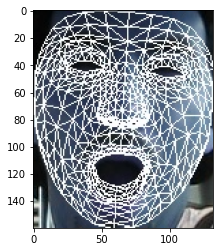

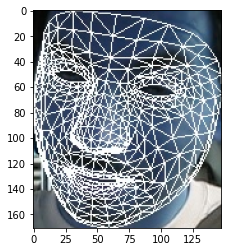

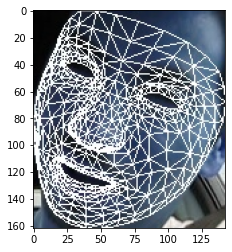

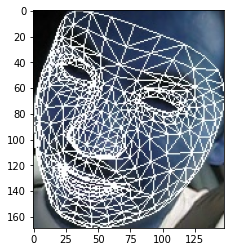

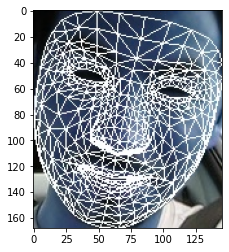

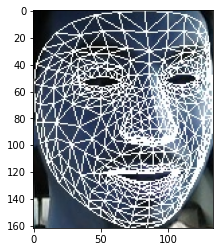

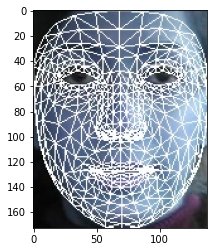

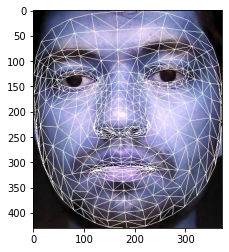

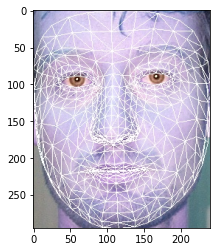

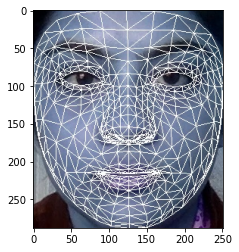

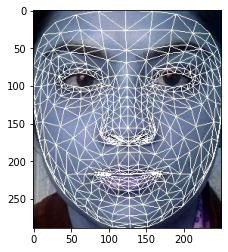

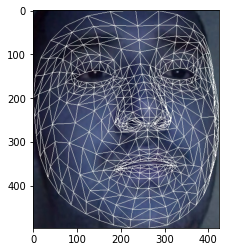

In [10]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
    for idx, img in enumerate(os.listdir(f'./{category}')):
        if idx > 5:
            break
        img_file = cv2.imread(f'./{category}/{img}')
        plt.imshow(img_file)
        plt.show()
        plt.close()

### Resizing images

In [11]:
import os
import time
def resizing_images(direc="./"):
    resized_images=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            resized_images.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return resized_images
resized_images = resizing_images()

0
1


## separate label and features

In [13]:
X = []
y = []
for feature, label in resized_images:
    X.append(feature)
    y.append(label)

## Reshape the array

In [14]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelEncoder

In [15]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

# Splitting

In [16]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, random_state=seed, test_size=test_size)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, random_state=seed, test_size=0.50)

In [17]:
print(len(X_test))
print(len(X_val))

1351
1351


In [18]:
len(X_train)

6302

### import some dependencies

In [19]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Augmentation

In [20]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
val_generator = ImageDataGenerator(rescale=1/255)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
val_generator = test_generator.flow(np.array(X_val), y_val, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [21]:
# Model Elsafty 1
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()
# Note the input shape is the desired size of the image 145 x 145 with 3 bytes color
# This is the first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The second convolution
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The third convolution
model.add(Conv2D(64, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The fourth convolution
model.add(Conv2D(128, 12, activation='relu'))
model.add(BatchNormalization())

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
# Only 1 output neuron.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 143, 143, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 143, 143, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 71, 71, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 67, 67, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 67, 67, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,423,713 (5.43 MB)

 Trainable params: 1,423,233 (5.43 MB)

 Non-trainable params: 480 (1.88 KB)

In [22]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


197/197 ━━━━━━━━━━━━━━━━━━━━ 162s 614ms/step - accuracy: 0.6711 - loss: 0.5876 - val_accuracy: 0.5588 - val_loss: 1.5078
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 111s 555ms/step - accuracy: 0.7861 - loss: 0.4370 - val_accuracy: 0.6699 - val_loss: 0.8427
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 109s 542ms/step - accuracy: 0.7970 - loss: 0.3950 - val_accuracy: 0.6728 - val_loss: 0.6083
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 108s 541ms/step - accuracy: 0.8387 - loss: 0.3436 - val_accuracy: 0.7091 - val_loss: 0.5696
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 109s 544ms/step - accuracy: 0.8522 - loss: 0.3206 - val_accuracy: 0.7646 - val_loss: 0.5321
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 108s 541ms/step - accuracy: 0.8661 - loss: 0.2947 - val_accuracy: 0.8261 - val_loss: 0.4162
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 109s 546ms/step - accuracy: 0.8770 - loss: 0.2823 - val_accuracy: 0.8601 - val_loss: 0.3423
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 107s 537ms/step - accuracy: 0.8931 - loss: 0.24

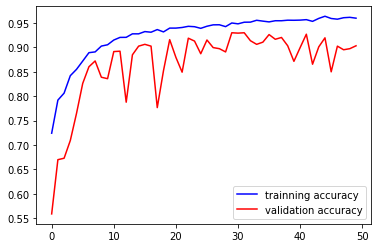

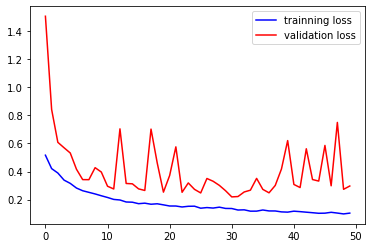

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [25]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8973 - loss: 0.2887


{'loss': 0.32083284854888916, 'compile_metrics': 0.897853434085846}

In [26]:
#serialize model structure to JSON
model_json = model.to_json()
with open("modelcomplete.json","w") as json_file :
    json_file.write(model_json)


from tensorflow.keras.models import save_model
save_model(model, "modelcomplete.h5")
# model.save('my_model.h5')
# model = tf.keras.models.load_model('my_model.h5')


# Visualizing our CNN architecture

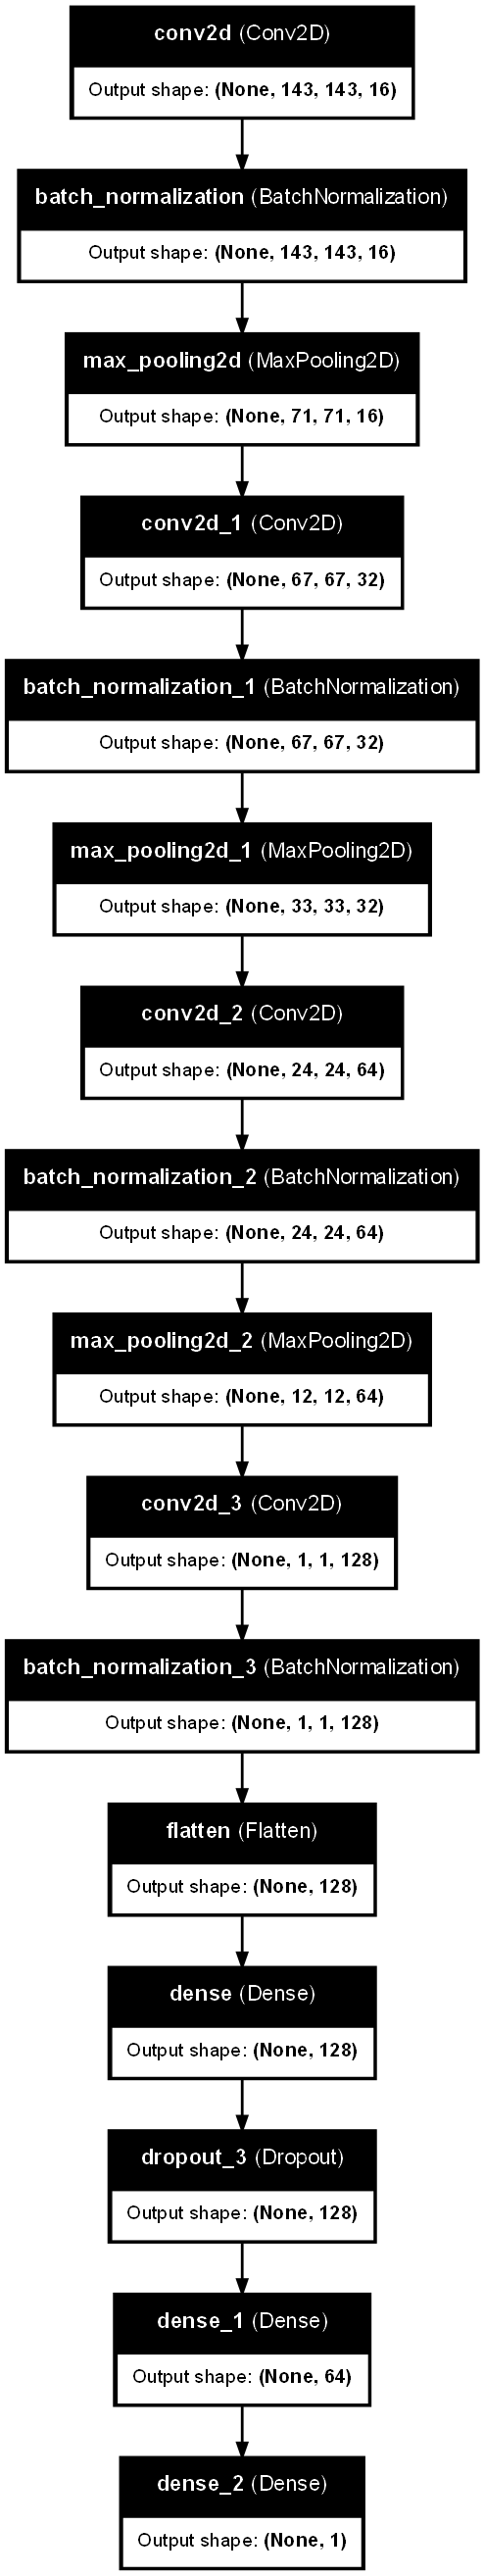

In [38]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=100)
from IPython.display import Image
Image("model.png")